# XGBoost Vegetation Classification

Supervised land cover **classification** or **regression** using XGBoost for Arctic/tundra vegetation mapping.

**Workflow:**
1. Configure prediction mode and input datasets
2. Load hyperspectral imagery, SAR data, and training labels
3. Train XGBoost model with optional class balancing
4. Predict on full imagery and visualize results
5. Export to GeoTIFF with embedded colormap

## 1. User Configuration

**MODIFY THIS SECTION FOR EACH RUN.** All commonly-changed parameters are here.

### Quick Start:
1. Set `PREDICTION_MODE` ('classification' or 'regression')
2. Set `TRAINING_DATA_MODE` ('raster' or 'vector') and configure the source
3. Verify `INPUT_DATASETS` paths match your data
4. Run all cells below

In [ ]:
# =============================================================================
# PREDICTION MODE
# =============================================================================
# 'classification' - Predict categorical classes (XGBClassifier)
# 'regression' - Predict continuous values (XGBRegressor, vector data only)
PREDICTION_MODE = 'regression'

# =============================================================================
# TRAINING DATA SOURCE
# =============================================================================
# 'raster' - Use a classified raster (LandcoverRef.tif) as training labels
# 'vector' - Use a GPKG/shapefile with point or polygon features
TRAINING_DATA_MODE = 'vector'

# Raster mode settings
LANDCOVER_PATH = "input/LandcoverRef.tif"

# Vector mode settings
VECTOR_TRAINING_CONFIG = {
    'path': "input/All_sumps_processed_GT_data_2024-2025.gpkg",
    'layer': None,                    # Layer name (None = default layer)
    'target_column': 'Plot_AGB',      # Attribute column for labels/values
    'buffer_radius_pixels': 2,        # Buffer around points (0 = point only)
    'buffer_cap_style': 'round',      # 'round', 'square', 'flat'
}

# Class mapping for vector classification (None = auto-generate alphabetically)
VECTOR_CLASS_MAPPING = None

# =============================================================================
# INPUT DATASETS
# =============================================================================
INPUT_DATASETS = [
    {
        'enabled': True,
        'name': 'Hyperspectral MNF',
        'short': 'FMNF',
        'path': 'input/Wyvern Tiles Nohistmatch FMNF',
        'pattern': '/*.dat',
        'bands': [1, 2, 3],
    },
    {
        'enabled': True,
        'name': 'SAR Pauli',
        'short': 'SAR',
        'path': 'input/SAR Pauli',
        'pattern': '/*.tif',
        'bands': [1, 2, 3],
        'nodata': 0,
    },
        {
        'enabled': False,
        'name': 'Drone CHM',
        'short': 'CHM',
        'path': 'input/CHM',
        'pattern': '/*.tif',
        'bands': [1],
        'nodata': -9999,
    },
]

# =============================================================================
# XGBOOST HYPERPARAMETERS
# =============================================================================
XGBOOST_PARAMS = {
    'n_estimators': 400,
    'max_depth': 11,
    'learning_rate': 0.0102,
    'min_child_weight': 1,
    'subsample': 0.7169,
    'colsample_bytree': 0.8470,
    'gamma': 0.0448,
    'reg_alpha': 0.0685,
    'reg_lambda': 0.1519,
    'random_state': 42,
    'n_jobs': -1,
    'device': 'cuda',
}

# =============================================================================
# CLASS BALANCING (Classification only)
# =============================================================================
# Majority classes capped at BALANCE_MULTIPLIER * minority_class_size
BALANCE_MULTIPLIER = 5

### 1.1 Advanced Configuration

Optional settings for fine-tuning. Modify only if needed.

In [2]:
# These imports are needed for RANDOM_SEARCH_PARAM_DIST_* below
from scipy.stats import uniform, randint, loguniform

# =============================================================================
# REGRESSION SETTINGS (only used when PREDICTION_MODE='regression')
# =============================================================================
REGRESSION_CONFIG = {
    'output_dtype': 'float32',      # Output raster data type
    'output_nodata': -9999,         # NoData value for output raster
    'clip_range': None,             # Optional (min, max) to clip predictions
    'filter_percentiles': None,     # Optional (lower, upper) to filter training outliers, e.g. (2, 98)
}

# =============================================================================
# SPECTRAL INDICES (Optional additional features)
# =============================================================================
SPECTRAL_INDICES_SOURCE = {
    'enabled': False,
    'name': 'Hyperspectral for Indices',
    'short': 'IDX',
    'path': 'input/Wyvern Tiles MNF3C',
    'pattern': '/*.dat',
}

SPECTRAL_INDICES = {
    'NDVI': {'enabled': True, 'bands': [31, 17], 'formula': 'normalized_difference'},
    'NDWI': {'enabled': True, 'bands': [9, 31], 'formula': 'normalized_difference'},
    'BSI':  {'enabled': True, 'bands': [15, 3, 31, 9], 'formula': 'bsi'},
}

# =============================================================================
# FEATURE STANDARDIZATION
# =============================================================================
# Options: None, 'standard' (zero mean, unit variance), 'minmax' (scale to 0-1)
STANDARDIZE_FEATURES = None

# =============================================================================
# VALIDATION & EARLY STOPPING
# =============================================================================
VALIDATION_SPLIT = 0.2

EARLY_STOPPING = {
    'enabled': True,
    'rounds': 20,
}

# =============================================================================
# RANDOM PARAMETER SEARCH (Advanced)
# =============================================================================
RANDOM_SEARCH_ENABLED = True

RANDOM_SEARCH_CONFIG = {
    'n_iter': 20,
    'cv': 3,
    'scoring_classification': 'accuracy',  # Options: 'accuracy', 'f1_weighted', 'balanced_accuracy'
    'scoring_regression': 'neg_root_mean_squared_error',  # Options: 'neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'
    'random_state': 42,
    'verbose': 2,
}

# Parameter distribution for classification (uses classifier__ prefix for pipeline)
RANDOM_SEARCH_PARAM_DIST_CLASSIFICATION = {
    'classifier__n_estimators': [100, 200, 400, 800, 1200, 1600],
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': loguniform(0.01, 0.3),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': loguniform(1e-3, 0.5),
    'classifier__reg_alpha': loguniform(1e-3, 1),
    'classifier__reg_lambda': loguniform(0.1, 2),
}

# Parameter distribution for regression (uses regressor__ prefix for pipeline)
RANDOM_SEARCH_PARAM_DIST_REGRESSION = {
    'regressor__n_estimators': [100, 200, 400, 800, 1200, 1600],
    'regressor__max_depth': randint(3, 15),
    'regressor__learning_rate': loguniform(0.01, 0.3),
    'regressor__min_child_weight': randint(1, 10),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__gamma': loguniform(1e-3, 0.5),
    'regressor__reg_alpha': loguniform(1e-3, 1),
    'regressor__reg_lambda': loguniform(0.1, 2),
}

# =============================================================================
# LAND COVER CLASSES (Classification mode)
# =============================================================================
# Note: Auto-generated from vector data when VECTOR_CLASS_MAPPING=None
CLASS_NAMES = {
    0: 'DST', 1: 'TST', 2: 'LTDST', 3: 'OST', 4: 'Wet',
    5: 'Waterbody', 6: 'PBHV', 7: 'Barren', 8: 'SASH', 9: 'BRN'
}

## 2. Imports

Load all required libraries. Run once at startup.

In [3]:
# Geospatial
import numpy as np
import xarray as xr
import rioxarray
import rasterio
from rasterio.enums import ColorInterp, Resampling
from rasterio.features import rasterize
from glob import glob
from datetime import datetime
import os
import colorsys

import geopandas as gpd
import fiona
from shapely.geometry import mapping

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import (cross_val_score, cross_val_predict,
    StratifiedKFold, KFold, RandomizedSearchCV, train_test_split)
from sklearn.metrics import (classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import uniform, randint, loguniform

# Visualization
import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import geoviews as gv
from geoviews import tile_sources as gvts
from bokeh.models import HoverTool, CustomJSHover, FixedTicker

hv.extension('bokeh')

print("All imports loaded successfully.")

c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


All imports loaded successfully.


## 3. Utility Functions

Helper functions used throughout the notebook. Run once - rarely need modification.

In [4]:
def get_dataset_info(path, pattern):
    files = glob(path + pattern)
    if not files:
        return None
    da = xr.open_dataarray(files[0], engine='rasterio')
    return {'crs': str(da.rio.crs), 'resolution': da.rio.resolution(), 'shape': da.shape, 'files': len(files)}

def get_vector_training_info(config, prediction_mode='classification'):
    """
    Get metadata about vector training file without fully loading.
    
    Returns dict with: path, layers, columns, shape, crs, geometry_type, unique_classes
    """
    if not os.path.exists(config['path']):
        return None
    
    # Get layer names
    layers = fiona.listlayers(config['path'])
    
    # Load specified layer (or default)
    gdf = gpd.read_file(config['path'], layer=config['layer'])
    
    target_col = config['target_column']
    unique_classes = None
    target_stats = None
    
    if target_col in gdf.columns:
        if prediction_mode == 'regression':
            # For regression, get numeric statistics
            target_values = gdf[target_col].dropna()
            try:
                target_numeric = target_values.astype(float)
                target_stats = {
                    'min': float(target_numeric.min()),
                    'max': float(target_numeric.max()),
                    'mean': float(target_numeric.mean()),
                    'std': float(target_numeric.std()),
                    'n_values': len(target_numeric)
                }
            except (ValueError, TypeError):
                target_stats = {'error': 'Target column is not numeric'}
        else:
            # For classification, get unique classes
            unique_classes = sorted([str(c) for c in gdf[target_col].dropna().unique()])
    
    result = {
        'path': config['path'],
        'layers': layers,
        'active_layer': config['layer'] or layers[0],
        'columns': [c for c in gdf.columns if c != 'geometry'],
        'n_features': len(gdf),
        'crs': str(gdf.crs),
        'geometry_types': gdf.geometry.geom_type.unique().tolist(),
        'target_column': target_col,
    }
    
    if prediction_mode == 'regression':
        result['target_stats'] = target_stats
    else:
        result['unique_classes'] = unique_classes
        result['n_classes'] = len(unique_classes) if unique_classes else 0
    
    return result

def load_vector_training_data(config, reference_da, class_mapping=None, prediction_mode='classification'):
    """
    Load vector training data from GPKG and rasterize to match reference grid.
    
    Parameters:
    -----------
    config : dict
        VECTOR_TRAINING_CONFIG dictionary
    reference_da : xarray.DataArray
        Reference grid to match (CRS, resolution, extent)
    class_mapping : dict or None
        Mapping from string labels to numeric codes (1-indexed for raster)
        Only used for classification mode.
    prediction_mode : str
        'classification' or 'regression'
        
    Returns:
    --------
    xarray.DataArray
        Rasterized training data matching reference grid
    dict or None
        Class mapping used (label -> raster value) for classification, None for regression
    int
        Original number of vector features
    """
    # Load GPKG
    gdf = gpd.read_file(config['path'], layer=config['layer'])
    original_count = len(gdf)
    
    # Validate target column exists
    target_col = config['target_column']
    if target_col not in gdf.columns:
        available = [c for c in gdf.columns if c != 'geometry']
        raise ValueError(f"Target column '{target_col}' not found. "
                        f"Available columns: {available}")
    
    # Filter out null target values
    null_count = gdf[target_col].isna().sum()
    gdf = gdf[gdf[target_col].notna()].copy()
    
    if len(gdf) == 0:
        raise ValueError(f"No valid training samples after filtering nulls")
    
    if null_count > 0:
        print(f"  Filtered {null_count} features with null target values")
    
    # Reproject to reference CRS if needed
    ref_crs = reference_da.rio.crs
    if gdf.crs != ref_crs:
        print(f"  Reprojecting from {gdf.crs} to {ref_crs}")
        gdf = gdf.to_crs(ref_crs)
    
    # Apply buffer if specified (convert from pixels to CRS units)
    buffer_pixels = config.get('buffer_radius_pixels', 0)
    if buffer_pixels > 0:
        # Get pixel size from reference grid (use average of x and y resolution)
        res = reference_da.rio.resolution()
        pixel_size = (abs(res[0]) + abs(res[1])) / 2
        buffer_crs_units = buffer_pixels * pixel_size
        
        cap_style_map = {'round': 1, 'flat': 2, 'square': 3}
        cap_style = cap_style_map.get(config.get('buffer_cap_style', 'round'), 1)
        gdf['geometry'] = gdf.geometry.buffer(buffer_crs_units, cap_style=cap_style)
        print(f"  Applied buffer: {buffer_pixels} pixels = {buffer_crs_units:.6f} CRS units")
    
    # Get rasterization parameters from reference grid
    transform = reference_da.rio.transform()
    out_shape = (reference_da.sizes['y'], reference_da.sizes['x'])
    
    if prediction_mode == 'regression':
        # REGRESSION MODE: Use numeric values directly
        try:
            target_values = gdf[target_col].astype('float32')
        except (ValueError, TypeError) as e:
            raise ValueError(f"Target column '{target_col}' must be numeric for regression mode. Error: {e}")
        
        # Prepare shapes for rasterization: (geometry, value) pairs
        shapes = [(mapping(geom), float(val)) for geom, val in zip(gdf.geometry, target_values)]
        
        # Rasterize with float values
        rasterized = rasterize(
            shapes=shapes,
            out_shape=out_shape,
            fill=np.nan,  # Use NaN as NoData for regression
            transform=transform,
            all_touched=True,
            dtype='float32'
        )
        
        rasterized_pixels = int(np.isfinite(rasterized).sum())
        print(f"  Rasterized {len(gdf)} features to {rasterized_pixels:,} training pixels (regression mode)")
        print(f"  Target value range: {target_values.min():.4f} to {target_values.max():.4f}")
        
        # Convert to xarray DataArray
        result = xr.DataArray(
            rasterized,
            dims=['y', 'x'],
            coords={'y': reference_da.coords['y'], 'x': reference_da.coords['x']},
            name='target'
        )
        result = result.rio.write_crs(ref_crs)
        
        return result, None, original_count
    
    else:
        # CLASSIFICATION MODE: Convert to integer class codes
        unique_classes = gdf[target_col].unique()
        if class_mapping is None:
            # Auto-generate mapping (1-indexed, alphabetically sorted)
            sorted_classes = sorted([str(c) for c in unique_classes])
            class_mapping = {cls: i+1 for i, cls in enumerate(sorted_classes)}
            print(f"  Auto-generated class mapping for {len(class_mapping)} classes")
        else:
            # Validate all classes in data have a mapping
            unmapped = set(str(c) for c in unique_classes) - set(str(k) for k in class_mapping.keys())
            if unmapped:
                print(f"  Warning: {len(unmapped)} classes not in mapping will be excluded: {unmapped}")
                gdf = gdf[gdf[target_col].astype(str).isin([str(k) for k in class_mapping.keys()])]
                if len(gdf) == 0:
                    raise ValueError("No features remaining after filtering by class mapping")
        
        # Convert target column to string for consistent mapping lookup
        gdf['_target_str'] = gdf[target_col].astype(str)
        
        # Prepare shapes for rasterization: (geometry, value) pairs
        shapes = []
        for geom, cls in zip(gdf.geometry, gdf['_target_str']):
            if cls in class_mapping:
                shapes.append((mapping(geom), class_mapping[cls]))
            elif str(cls) in [str(k) for k in class_mapping.keys()]:
                # Find the matching key
                for k, v in class_mapping.items():
                    if str(k) == str(cls):
                        shapes.append((mapping(geom), v))
                        break
        
        # Rasterize
        rasterized = rasterize(
            shapes=shapes,
            out_shape=out_shape,
            fill=0,  # NoData value
            transform=transform,
            all_touched=True,
            dtype='uint8'
        )
        
        # Convert to xarray DataArray matching reference grid
        result = xr.DataArray(
            rasterized.astype('float32'),
            dims=['y', 'x'],
            coords={'y': reference_da.coords['y'], 'x': reference_da.coords['x']},
            name='landcover'
        )
        result = result.rio.write_crs(ref_crs)
        result = result.where(result != 0)  # Set 0 to NaN for consistency with raster mode
        
        rasterized_pixels = int((rasterized > 0).sum())
        print(f"  Rasterized {len(gdf)} features to {rasterized_pixels:,} training pixels")
        
        return result, class_mapping, original_count

In [5]:
# =============================================================================
# TRAINING HELPER FUNCTIONS
# =============================================================================

def make_sampling_strategy(multiplier):
    """Create a sampling strategy for RandomUnderSampler."""
    def strategy(y):
        unique, counts = np.unique(y, return_counts=True)
        max_samples = counts.min() * multiplier
        return {cls: min(count, max_samples) for cls, count in zip(unique, counts)}
    return strategy

def log_section(title, content):
    """Add a section to the run log."""
    RUN_LOG['sections'].append({'title': title, 'content': content})

## 4. Initialize Run

Validate configuration and set up output paths for the current run.

In [6]:
# =============================================================================
# VALIDATE CONFIGURATION
# =============================================================================
if PREDICTION_MODE == 'regression' and TRAINING_DATA_MODE != 'vector':
    raise ValueError("Regression mode is only supported with vector training data (TRAINING_DATA_MODE='vector')")

# =============================================================================
# INITIALIZE RUN STATE
# =============================================================================
RUN_TIMESTAMP = datetime.now()
RUN_LOG = {
    'timestamp': RUN_TIMESTAMP.strftime('%Y-%m-%d %H:%M:%S'),
    'sections': []
}
LEARNING_CURVES = {}
FEATURE_SCALER = None

# =============================================================================
# BUILD OUTPUT FILENAME
# =============================================================================
OUTPUT_DIR = "output"

# Determine output prefix based on training mode
if TRAINING_DATA_MODE == 'vector':
    _output_prefix = VECTOR_TRAINING_CONFIG['target_column'].upper()
else:
    _output_prefix = 'LC'

_parts = [ds['short'] for ds in INPUT_DATASETS if ds.get('enabled', True)]
_enabled_indices = [name for name, cfg in SPECTRAL_INDICES.items() if cfg.get('enabled', True)]
if SPECTRAL_INDICES_SOURCE['enabled'] and _enabled_indices:
    _parts.append(f"{SPECTRAL_INDICES_SOURCE['short']}({'+'.join(_enabled_indices)})")

if PREDICTION_MODE == 'regression':
    _parts.append('REG')

OUTPUT_BASE = f"{_output_prefix}_{'_'.join(_parts)}_{RUN_TIMESTAMP.strftime('%m%d_%H%M')}"
RUN_OUTPUT_DIR = f"{OUTPUT_DIR}/{OUTPUT_BASE}"
OUTPUT_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}.tif"
LOG_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}.txt"
CURVES_PATH = f"{RUN_OUTPUT_DIR}/{OUTPUT_BASE}_learning_curves.png"

os.makedirs(RUN_OUTPUT_DIR, exist_ok=True)

print(f"Run initialized: {RUN_TIMESTAMP.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Prediction mode: {PREDICTION_MODE}")
print(f"Output folder: {RUN_OUTPUT_DIR}")

Run initialized: 2026-01-29 11:02:00
Prediction mode: regression
Output folder: output/PLOT_AGB_CHM_REG_0129_1102


## 5. Load Training Data

Load all input datasets and the reference land cover raster.

**Native Grid Approach:** Features are kept in their native CRS to avoid reprojection artifacts.

In [7]:
# Collect input data metadata
input_log = []

for config in INPUT_DATASETS:
    if not config.get('enabled', True):
        continue
    info = get_dataset_info(config['path'], config['pattern'])
    if info:
        input_log.append(f"{config['name']}:")
        input_log.append(f"  Path: {config['path']}{config['pattern']}")
        input_log.append(f"  Bands: {config['bands']}")
        input_log.append(f"  CRS: {info['crs']}, Resolution: {info['resolution']}, Shape: {info['shape']}")
        if 'nodata' in config:
            input_log.append(f"  NoData: {config['nodata']}")

if SPECTRAL_INDICES_SOURCE['enabled']:
    idx_info = get_dataset_info(SPECTRAL_INDICES_SOURCE['path'], SPECTRAL_INDICES_SOURCE['pattern'])
    if idx_info:
        input_log.append(f"\nSpectral Indices Source:")
        input_log.append(f"  Path: {SPECTRAL_INDICES_SOURCE['path']}{SPECTRAL_INDICES_SOURCE['pattern']}")
        input_log.append(f"  CRS: {idx_info['crs']}, Resolution: {idx_info['resolution']}, Shape: {idx_info['shape']}")
        input_log.append(f"  Indices: {[k for k,v in SPECTRAL_INDICES.items() if v.get('enabled')]}")

# Load primary dataset as reference grid
def load_raster_tiles(path, pattern, bands_to_select=None):
    files = sorted(glob(path + pattern))
    if not files:
        return None
    
    if len(files) == 1:
        da = xr.open_dataarray(files[0], engine='rasterio')
        if bands_to_select is not None and 'band' in da.dims:
            da = da.sel(band=bands_to_select)
        return da
    
    def preprocess(ds):
        da = ds['band_data'] if 'band_data' in ds else ds.to_array().squeeze('variable')
        if bands_to_select is not None and 'band' in da.dims:
            da = da.sel(band=bands_to_select)
        da.attrs = {}
        return da.to_dataset(name='data')
    
    ds = xr.open_mfdataset(files, engine='rasterio', combine='by_coords',
                           preprocess=preprocess, combine_attrs='drop_conflicts')
    return ds['data']

enabled_datasets = [ds for ds in INPUT_DATASETS if ds.get('enabled', True)]
if not enabled_datasets:
    raise ValueError("No enabled input datasets!")
primary_config = enabled_datasets[0]

bands_to_load = primary_config['bands'] if primary_config['bands'] != 'all' else None
primary_da = load_raster_tiles(primary_config['path'], primary_config['pattern'], bands_to_select=bands_to_load)

reference_grid = primary_da.isel(band=0) if 'band' in primary_da.dims else primary_da
NATIVE_CRS = str(reference_grid.rio.crs)

# =============================================================================
# LOAD TRAINING DATA (RASTER OR VECTOR MODE)
# =============================================================================

used_class_mapping = None  # Will be set for classification mode

if TRAINING_DATA_MODE == 'vector':
    print(f"Loading vector training data from: {VECTOR_TRAINING_CONFIG['path']}")
    print(f"Prediction mode: {PREDICTION_MODE}")
    
    # Get info for logging
    vector_info = get_vector_training_info(VECTOR_TRAINING_CONFIG, prediction_mode=PREDICTION_MODE)
    if vector_info is None:
        raise FileNotFoundError(f"Vector file not found: {VECTOR_TRAINING_CONFIG['path']}")
    
    input_log.append(f"\nTraining Data Source: VECTOR")
    input_log.append(f"  Path: {vector_info['path']}")
    input_log.append(f"  Layer: {vector_info['active_layer']}")
    input_log.append(f"  Features: {vector_info['n_features']}")
    input_log.append(f"  CRS: {vector_info['crs']}")
    input_log.append(f"  Geometry Types: {vector_info['geometry_types']}")
    input_log.append(f"  Target Column: {vector_info['target_column']}")
    input_log.append(f"  Prediction Mode: {PREDICTION_MODE}")
    input_log.append(f"  Buffer Radius: {VECTOR_TRAINING_CONFIG['buffer_radius_pixels']} pixels")
    
    if PREDICTION_MODE == 'regression':
        if vector_info.get('target_stats'):
            stats = vector_info['target_stats']
            if 'error' in stats:
                input_log.append(f"  Target Stats Error: {stats['error']}")
            else:
                input_log.append(f"  Target Stats: min={stats['min']:.4f}, max={stats['max']:.4f}, "
                               f"mean={stats['mean']:.4f}, std={stats['std']:.4f}")
    else:
        if vector_info.get('unique_classes'):
            input_log.append(f"  Classes Found: {vector_info['n_classes']} - {vector_info['unique_classes']}")
    
    # Load and rasterize
    lc_ds, used_class_mapping, original_feature_count = load_vector_training_data(
        VECTOR_TRAINING_CONFIG, 
        reference_grid,
        class_mapping=VECTOR_CLASS_MAPPING,
        prediction_mode=PREDICTION_MODE
    )
    
    if PREDICTION_MODE == 'classification':
        # Update CLASS_NAMES if using auto-generated mapping
        if VECTOR_CLASS_MAPPING is None and used_class_mapping is not None:
            CLASS_NAMES = {v-1: k for k, v in used_class_mapping.items()}  # 0-indexed for XGBoost
            print(f"Updated CLASS_NAMES: {CLASS_NAMES}")
        
        input_log.append(f"  Class Mapping Used:")
        for cls_name, cls_value in sorted(used_class_mapping.items(), key=lambda x: x[1]):
            input_log.append(f"    {cls_value}: {cls_name}")
    
    input_log.append(f"  Rasterized Training Pixels: {int(lc_ds.notnull().sum().values):,}")

else:
    # Raster mode (existing code) - only supports classification
    if PREDICTION_MODE == 'regression':
        raise ValueError("Regression mode is only supported with vector training data")
    
    print(f"Loading raster training data from: {LANDCOVER_PATH}")
    
    lc_info = get_dataset_info('input', '/LandcoverRef.tif')
    input_log.append(f"\nTraining Data Source: RASTER")
    input_log.append(f"  Path: {LANDCOVER_PATH}")
    if lc_info:
        input_log.append(f"  CRS: {lc_info['crs']}, Resolution: {lc_info['resolution']}, Shape: {lc_info['shape']}")
    
    lc_ds_orig = xr.open_dataarray(LANDCOVER_PATH, engine='rasterio')
    lc_ds = lc_ds_orig.rio.reproject_match(reference_grid, resampling=Resampling.nearest)

log_section("INPUT DATA", "\n".join(input_log))

# Load all datasets
def load_dataset_native(config, reference_da):
    name = config.get('name', config['path'])
    files = glob(config['path'] + config['pattern'])
    if not files:
        raise FileNotFoundError(f"No files found for {name}")
    
    bands_to_load = config['bands'] if config['bands'] != 'all' else None
    da = load_raster_tiles(config['path'], config['pattern'], bands_to_select=bands_to_load)
    
    if 'nodata' in config:
        da = da.where(da != config['nodata'])
    
    if da.rio.crs != reference_da.rio.crs:
        da = da.rio.reproject_match(reference_da, resampling=Resampling.bilinear)
    
    return da

def calculate_spectral_indices_native(source_config, indices_config, reference_da):
    if not source_config.get('enabled', False):
        return [], []
    
    enabled_indices = {name: cfg for name, cfg in indices_config.items() if cfg.get('enabled', True)}
    if not enabled_indices:
        return [], []
    
    files = glob(source_config['path'] + source_config['pattern'])
    if not files:
        return [], []
    
    required_bands = sorted(set(b for cfg in enabled_indices.values() for b in cfg['bands']))
    hs_da = load_raster_tiles(source_config['path'], source_config['pattern'], bands_to_select=required_bands)
    
    if hs_da.rio.crs != reference_da.rio.crs or hs_da.shape[-2:] != reference_da.shape[-2:]:
        hs_da = hs_da.rio.reproject_match(reference_da, resampling=Resampling.bilinear)
    
    indices_data, indices_names = [], []
    
    for idx_name, idx_config in enabled_indices.items():
        bands = idx_config['bands']
        formula = idx_config['formula']
        
        try:
            if formula == 'normalized_difference':
                b1 = hs_da.sel(band=bands[0]).astype('float32')
                b2 = hs_da.sel(band=bands[1]).astype('float32')
                result = xr.where((b1 + b2) != 0, (b1 - b2) / (b1 + b2), np.nan)
            elif formula == 'bsi':
                red, blue, nir, green = [hs_da.sel(band=b).astype('float32') for b in bands]
                num = (red + blue) - (nir + green)
                denom = (red + blue) + (nir + green)
                result = xr.where(denom != 0, num / denom, np.nan)
            else:
                continue
            
            result = result.drop_vars('band', errors='ignore').squeeze()
            indices_data.append(result)
            indices_names.append(idx_name)
        except Exception as e:
            print(f"  Failed {idx_name}: {e}")
    
    return indices_data, indices_names

# Load all features
all_features, feature_names = [], []

for config in INPUT_DATASETS:
    if not config.get('enabled', True):
        continue
    try:
        da = load_dataset_native(config, reference_grid)
        if 'band' in da.dims:
            for band in da.band.values:
                all_features.append(da.sel(band=band).drop_vars('band', errors='ignore'))
                feature_names.append(f"{config['name']}_band{band}")
        else:
            all_features.append(da.drop_vars('band', errors='ignore'))
            feature_names.append(config['name'])
    except Exception as e:
        print(f"Failed to load {config['name']}: {e}")

indices_data, indices_names = calculate_spectral_indices_native(SPECTRAL_INDICES_SOURCE, SPECTRAL_INDICES, reference_grid)
all_features.extend(indices_data)
feature_names.extend(indices_names)

# Stack features
stacked_ds = xr.Dataset({name: feat.squeeze() for name, feat in zip(feature_names, all_features)})
target_var_name = 'target' if PREDICTION_MODE == 'regression' else 'landcover'
stacked_ds[target_var_name] = lc_ds.squeeze().drop_vars('band', errors='ignore')
stacked_ds = stacked_ds.rio.write_crs(NATIVE_CRS)

# Coverage statistics
total_pixels = int(np.prod([stacked_ds.sizes[d] for d in ['y', 'x']]))
target_valid = stacked_ds[target_var_name].notnull()
features_valid = xr.concat([stacked_ds[name].notnull() for name in feature_names], dim='feature').all(dim='feature')
both_valid = target_valid & features_valid

feature_log = [f"Native CRS: {NATIVE_CRS}", f"Resolution: {reference_grid.rio.resolution()}", f"Shape: {reference_grid.shape}", ""]
feature_log.append("Features:")
for name in feature_names:
    feature_log.append(f"  - {name}")
feature_log.append("")
feature_log.append(f"Total pixels: {total_pixels:,}")
feature_log.append(f"Valid for training: {int(both_valid.sum().values):,} ({100*both_valid.sum().values/total_pixels:.1f}%)")
log_section("FEATURE STACK", "\n".join(feature_log))

print(f"Loaded {len(feature_names)} features. Valid training pixels: {int(both_valid.sum().values):,}")
stacked_ds

C:\Users\lili0243\AppData\Local\Temp\ipykernel_179684\2921216023.py:43: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  ds = xr.open_mfdataset(files, engine='rasterio', combine='by_coords',


Loading vector training data from: input/All_sumps_processed_GT_data_2024-2025.gpkg
Prediction mode: regression
  Filtered 115 features with null target values
  Applied buffer: 1 pixels = 1.000000 CRS units
  Rasterized 151 features to 327 training pixels (regression mode)
  Target value range: 12.5474 to 7480.6401


c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'All_sumps_processed_GT_data_2024-2025.gpkg': 'All_processed_GT_data_2024-2025' (default), 'Delineated_sump_sites_2024-2025', 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'All_sumps_processed_GT_data_2024-2025.gpkg': 'All_processed_GT_data_2024-2025' (default), 'Delineated_sump_sites_2024-2025', 'layer_styles'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\lili0243\AppData\Local\Temp\ipykernel_179684\2921216023.py:43: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal alo

Loaded 1 features. Valid training pixels: 327


<xarray.Dataset> Size: 18MB
Dimensions:          (x: 1311, y: 1741)
Coordinates:
  * x                (x) float64 10kB 5.75e+05 5.75e+05 ... 5.776e+05 5.776e+05
  * y                (y) float64 14kB 7.692e+06 7.692e+06 ... 7.69e+06 7.69e+06
    spatial_ref      int64 8B 0
Data variables:
    Drone CHM_band1  (y, x) float32 9MB dask.array<chunksize=(128, 117), meta=np.ndarray>
    target           (y, x) float32 9MB nan nan nan nan nan ... nan nan nan nan

## 6. Train XGBoost Model

Train the model with cross-validation and early stopping.

- **Classification:** XGBClassifier with RandomUnderSampler for class balancing
- **Regression:** XGBRegressor without class balancing

In [8]:
# Prepare training data
X = np.stack([stacked_ds[name].values.flatten() for name in feature_names], axis=1)
target_var_name = 'target' if PREDICTION_MODE == 'regression' else 'landcover'
y = stacked_ds[target_var_name].values.flatten()

# Filter valid pixels based on prediction mode
if PREDICTION_MODE == 'regression':
    # For regression: just filter out NaN values
    valid_idx = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
    X, y = X[valid_idx], y[valid_idx].astype('float32')
    
    # Apply percentile filtering if configured
    filter_pct = REGRESSION_CONFIG.get('filter_percentiles')
    if filter_pct is not None:
        lower_pct, upper_pct = filter_pct
        lower_val = np.percentile(y, lower_pct)
        upper_val = np.percentile(y, upper_pct)
        pct_mask = (y >= lower_val) & (y <= upper_val)
        n_removed = len(y) - pct_mask.sum()
        X, y = X[pct_mask], y[pct_mask]
        print(f"Percentile filter ({lower_pct}-{upper_pct}): removed {n_removed:,} samples, keeping {len(y):,}")
        print(f"  Value range after filter: {y.min():.4f} to {y.max():.4f}")
else:
    # For classification: filter valid pixels within class range
    n_classes = len(CLASS_NAMES)
    valid_idx = ~np.isnan(y) & ~np.isnan(X).any(axis=1) & (y >= 1) & (y <= n_classes)
    X, y = X[valid_idx], y[valid_idx].astype(int) - 1  # Convert to 0-indexed for XGBoost

# Optional feature standardization
if STANDARDIZE_FEATURES:
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    if STANDARDIZE_FEATURES == 'standard':
        FEATURE_SCALER = StandardScaler()
        print("Applying StandardScaler (zero mean, unit variance)...")
    elif STANDARDIZE_FEATURES == 'minmax':
        FEATURE_SCALER = MinMaxScaler()
        print("Applying MinMaxScaler (scale to 0-1)...")
    else:
        raise ValueError(f"Unknown standardization method: {STANDARDIZE_FEATURES}")
    
    X = FEATURE_SCALER.fit_transform(X)
    print(f"  Feature means: {X.mean(axis=0).round(4)}")
    print(f"  Feature stds:  {X.std(axis=0).round(4)}")
else:
    FEATURE_SCALER = None

# Log training data statistics
training_log = []
overfitting_log = []

if PREDICTION_MODE == 'regression':
    # REGRESSION MODE
    print(f"Regression mode: {len(y):,} training samples")
    
    class_dist = [f"Training samples: {len(y):,}, Features: {len(feature_names)}", ""]
    class_dist.append(f"Prediction Mode: REGRESSION")
    class_dist.append(f"Target Column: {VECTOR_TRAINING_CONFIG['target_column']}")
    if STANDARDIZE_FEATURES:
        class_dist.append(f"Feature Standardization: {STANDARDIZE_FEATURES}")
    if REGRESSION_CONFIG.get('filter_percentiles'):
        class_dist.append(f"Percentile Filter: {REGRESSION_CONFIG['filter_percentiles'][0]}th to {REGRESSION_CONFIG['filter_percentiles'][1]}th")
    class_dist.append("")
    class_dist.append("Target Value Distribution (after filtering):")
    class_dist.append(f"  Min:    {y.min():.4f}")
    class_dist.append(f"  Max:    {y.max():.4f}")
    class_dist.append(f"  Mean:   {y.mean():.4f}")
    class_dist.append(f"  Std:    {y.std():.4f}")
    class_dist.append(f"  Median: {np.median(y):.4f}")
    log_section("TARGET DISTRIBUTION", "\n".join(class_dist))
    
    if RANDOM_SEARCH_ENABLED:
        # RANDOM SEARCH FOR REGRESSION
        scoring_metric = RANDOM_SEARCH_CONFIG.get('scoring_regression', 'neg_root_mean_squared_error')
        print(f"Running randomized parameter search ({RANDOM_SEARCH_CONFIG['n_iter']} iterations, {RANDOM_SEARCH_CONFIG['cv']}-fold CV)...")
        training_log.append("Mode: Randomized Parameter Search (Regression)")
        training_log.append(f"Iterations: {RANDOM_SEARCH_CONFIG['n_iter']}")
        training_log.append(f"CV Folds: {RANDOM_SEARCH_CONFIG['cv']}")
        training_log.append(f"Scoring: {scoring_metric}")
        training_log.append("")
        
        # Create pipeline with regressor (no undersampler for regression)
        pipeline = Pipeline([
            ('regressor', xgb.XGBRegressor(**XGBOOST_PARAMS))
        ])
        
        random_search = RandomizedSearchCV(
            pipeline, param_distributions=RANDOM_SEARCH_PARAM_DIST_REGRESSION,
            n_iter=RANDOM_SEARCH_CONFIG['n_iter'],
            cv=KFold(n_splits=RANDOM_SEARCH_CONFIG['cv'], shuffle=True, random_state=42),
            scoring=scoring_metric,
            random_state=RANDOM_SEARCH_CONFIG['random_state'],
            verbose=RANDOM_SEARCH_CONFIG['verbose'],
            n_jobs=1, return_train_score=True
        )
        random_search.fit(X, y)
        
        # Log all CV results with iteration details
        training_log.append("All Parameter Combinations Tested:")
        training_log.append("-" * 80)
        cv_results = random_search.cv_results_
        sorted_idx = np.argsort(cv_results['rank_test_score'])
        for rank_i, i in enumerate(sorted_idx):
            params_str = ", ".join(f"{k.replace('regressor__', '')}={v:.4f}" if isinstance(v, float) else f"{k.replace('regressor__', '')}={v}" 
                                   for k, v in cv_results['params'][i].items())
            # For regression, scores may be negative (neg_rmse), so display absolute value for clarity
            mean_score = cv_results['mean_test_score'][i]
            std_score = cv_results['std_test_score'][i]
            if scoring_metric.startswith('neg_'):
                display_score = f"{-mean_score:.4f}"
                display_metric = scoring_metric.replace('neg_', '')
            else:
                display_score = f"{mean_score:.4f}"
                display_metric = scoring_metric
            training_log.append(f"#{rank_i+1} ({display_metric}={display_score} +/- {std_score:.4f})")
            training_log.append(f"    {params_str}")
        
        training_log.append("")
        training_log.append("Best Parameters:")
        best_params = {}
        for param, value in sorted(random_search.best_params_.items()):
            param_name = param.replace('regressor__', '')
            best_params[param_name] = value
            training_log.append(f"  {param_name}: {value:.4f}" if isinstance(value, float) else f"  {param_name}: {value}")
        
        # Display best score appropriately
        best_score = random_search.best_score_
        if scoring_metric.startswith('neg_'):
            training_log.append(f"\nBest CV {scoring_metric.replace('neg_', '')}: {-best_score:.4f}")
        else:
            training_log.append(f"\nBest CV {scoring_metric}: {best_score:.4f}")
        
        # Overfitting analysis from CV results
        best_idx = random_search.best_index_
        train_score = cv_results['mean_train_score'][best_idx]
        test_score = cv_results['mean_test_score'][best_idx]
        train_std = cv_results['std_train_score'][best_idx]
        test_std = cv_results['std_test_score'][best_idx]
        
        # For negative scoring metrics, convert for display
        if scoring_metric.startswith('neg_'):
            display_train = -train_score
            display_test = -test_score
            overfit_gap = display_test - display_train  # Higher is worse for error metrics
            metric_name = scoring_metric.replace('neg_', '')
        else:
            display_train = train_score
            display_test = test_score
            overfit_gap = display_train - display_test
            metric_name = scoring_metric
        
        overfitting_log.append("Cross-Validation Scores (Best Model):")
        overfitting_log.append(f"  Train {metric_name}: {display_train:.4f} (+/- {train_std:.4f})")
        overfitting_log.append(f"  Test {metric_name}:  {display_test:.4f} (+/- {test_std:.4f})")
        overfitting_log.append(f"  Gap: {overfit_gap:.4f}")
        overfitting_log.append("")
        
        if abs(overfit_gap) > 0.1 * abs(display_test):
            overfitting_log.append("  WARNING: Large train-test gap suggests overfitting")
        elif abs(overfit_gap) > 0.05 * abs(display_test):
            overfitting_log.append("  CAUTION: Moderate train-test gap")
        else:
            overfitting_log.append("  OK: Train-test gap is acceptable")
        
        # Update XGBOOST_PARAMS with best parameters
        for param, value in best_params.items():
            if param in XGBOOST_PARAMS:
                XGBOOST_PARAMS[param] = value
        
        # Get predictions for metrics calculation
        y_pred_cv = random_search.predict(X)
        cv_rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
        cv_mae = mean_absolute_error(y, y_pred_cv)
        cv_r2 = r2_score(y, y_pred_cv)
        
        training_log.append("")
        training_log.append("Regression Metrics (Best Model on Full Data):")
        training_log.append(f"  RMSE: {cv_rmse:.4f}")
        training_log.append(f"  MAE:  {cv_mae:.4f}")
        training_log.append(f"  R²:   {cv_r2:.4f}")
        
        # Store for later use
        optimal_n_estimators = best_params.get('n_estimators', XGBOOST_PARAMS['n_estimators'])
        
    else:
        # Standard cross-validation for regression (no random search)
        print("Running 5-fold cross-validation (regression)...")
        training_log.append("Mode: 5-Fold Cross-Validation (Regression)")
        training_log.append("")
        
        # Create regressor (no class balancing for regression)
        regressor = xgb.XGBRegressor(**XGBOOST_PARAMS)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(regressor, X, y, cv=cv)
        
        # Calculate regression metrics
        cv_rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
        cv_mae = mean_absolute_error(y, y_pred_cv)
        cv_r2 = r2_score(y, y_pred_cv)
        
        training_log.append(f"CV RMSE: {cv_rmse:.4f}")
        training_log.append(f"CV MAE:  {cv_mae:.4f}")
        training_log.append(f"CV R²:   {cv_r2:.4f}")
        training_log.append("")
        training_log.append("XGBoost Parameters Used:")
        for param, value in XGBOOST_PARAMS.items():
            if param not in ['random_state', 'n_jobs']:
                training_log.append(f"  {param}: {value}")
        
        optimal_n_estimators = None  # Will be set by early stopping
    
    # Train with eval_set for learning curves
    print("Training model with learning curve tracking...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=VALIDATION_SPLIT, random_state=42
    )
    
    early_stop_rounds = EARLY_STOPPING['rounds'] if EARLY_STOPPING['enabled'] else None
    diagnostic_params = {**XGBOOST_PARAMS, 'early_stopping_rounds': early_stop_rounds}
    clf_diagnostic = xgb.XGBRegressor(**diagnostic_params)
    clf_diagnostic.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    
    # Extract learning curves (RMSE for regression)
    results = clf_diagnostic.evals_result()
    LEARNING_CURVES['train_error'] = results['validation_0']['rmse']
    LEARNING_CURVES['val_error'] = results['validation_1']['rmse']
    LEARNING_CURVES['n_estimators'] = len(LEARNING_CURVES['train_error'])
    LEARNING_CURVES['metric_name'] = 'RMSE'
    
    # Determine optimal n_estimators
    if RANDOM_SEARCH_ENABLED and optimal_n_estimators is not None:
        # Use n_estimators from random search
        LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
        print(f"Using n_estimators from random search: {optimal_n_estimators}")
    elif EARLY_STOPPING['enabled']:
        optimal_n_estimators = clf_diagnostic.best_iteration + 1
        LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
        print(f"Early stopping: optimal n_estimators = {optimal_n_estimators}")
    else:
        min_val_idx = np.argmin(LEARNING_CURVES['val_error'])
        optimal_n_estimators = min_val_idx + 1
        LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
    
    # Calculate validation metrics
    train_pred = clf_diagnostic.predict(X_train)
    val_pred = clf_diagnostic.predict(X_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    overfitting_log.append("Final Model Training Metrics (Regression):")
    overfitting_log.append(f"  Total samples: {len(y):,}")
    overfitting_log.append(f"  Train split: {len(y_train):,} ({100*(1-VALIDATION_SPLIT):.0f}%)")
    overfitting_log.append(f"  Validation split: {len(y_val):,} ({100*VALIDATION_SPLIT:.0f}%)")
    overfitting_log.append("")
    overfitting_log.append(f"  Train RMSE: {train_rmse:.4f}")
    overfitting_log.append(f"  Val RMSE:   {val_rmse:.4f}")
    overfitting_log.append(f"  RMSE Gap:   {val_rmse - train_rmse:.4f}")
    overfitting_log.append("")
    overfitting_log.append(f"  Train R²:   {train_r2:.4f}")
    overfitting_log.append(f"  Val R²:     {val_r2:.4f}")
    overfitting_log.append("")
    
    # Learning curve analysis
    final_train_loss = LEARNING_CURVES['train_error'][-1]
    final_val_loss = LEARNING_CURVES['val_error'][-1]
    min_val_loss = min(LEARNING_CURVES['val_error'])
    min_val_epoch = LEARNING_CURVES['val_error'].index(min_val_loss) + 1
    
    overfitting_log.append("Learning Curve Analysis:")
    overfitting_log.append(f"  Final Train RMSE: {final_train_loss:.4f}")
    overfitting_log.append(f"  Final Val RMSE:   {final_val_loss:.4f}")
    overfitting_log.append(f"  Best Val RMSE:    {min_val_loss:.4f} (epoch {min_val_epoch})")
    
    if EARLY_STOPPING['enabled']:
        overfitting_log.append(f"  Early Stopping: enabled (patience={EARLY_STOPPING['rounds']})")
        overfitting_log.append(f"  Optimal n_estimators: {LEARNING_CURVES['optimal_n_estimators']}")
    
    # Retrain on full dataset
    print(f"Retraining final model on full dataset (n_estimators={optimal_n_estimators})...")
    final_params = {k: v for k, v in XGBOOST_PARAMS.items() if k != 'early_stopping_rounds'}
    final_params['n_estimators'] = optimal_n_estimators
    clf = xgb.XGBRegressor(**final_params)
    clf.fit(X, y, verbose=False)
    
    training_log.append(f"\nFinal model: n_estimators={optimal_n_estimators}")
    training_log.append("")
    training_log.append("Feature Importance:")
    for idx in np.argsort(clf.feature_importances_)[::-1]:
        training_log.append(f"  {feature_names[idx]:30s}: {clf.feature_importances_[idx]:.4f}")
    
    # Store CV metrics for display
    cv_accuracy = cv_r2  # Use R² as the primary metric display
    val_acc = val_r2
    
    print(f"Training complete. CV R²: {cv_r2:.4f}, Val RMSE: {val_rmse:.4f}")

else:
    # CLASSIFICATION MODE (existing code)
    n_classes = len(CLASS_NAMES)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist = [f"Training samples: {len(y):,}, Features: {len(feature_names)}", ""]
    class_dist.append(f"Prediction Mode: CLASSIFICATION")
    class_dist.append(f"Number of classes: {n_classes}")
    if STANDARDIZE_FEATURES:
        class_dist.append(f"Feature Standardization: {STANDARDIZE_FEATURES}")
    class_dist.append("")
    class_dist.append("Class Distribution:")
    for cls, count in zip(unique, counts):
        class_name = CLASS_NAMES.get(cls, f"Class_{cls}")
        class_dist.append(f"  {class_name:12s}: {count:6,} ({100*count/len(y):5.1f}%)")
    log_section("CLASS DISTRIBUTION", "\n".join(class_dist))
    
    # Sampling strategy
    def make_sampling_strategy(multiplier):
        def strategy(y):
            unique, counts = np.unique(y, return_counts=True)
            max_samples = counts.min() * multiplier
            return {cls: min(count, max_samples) for cls, count in zip(unique, counts)}
        return strategy
    
    if RANDOM_SEARCH_ENABLED:
        scoring_metric = RANDOM_SEARCH_CONFIG.get('scoring_classification', 'accuracy')
        print(f"Running randomized parameter search ({RANDOM_SEARCH_CONFIG['n_iter']} iterations, {RANDOM_SEARCH_CONFIG['cv']}-fold CV)...")
        training_log.append("Mode: Randomized Parameter Search")
        training_log.append(f"Iterations: {RANDOM_SEARCH_CONFIG['n_iter']}")
        training_log.append(f"CV Folds: {RANDOM_SEARCH_CONFIG['cv']}")
        training_log.append(f"Scoring: {scoring_metric}")
        training_log.append("")
        
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)),
            ('classifier', xgb.XGBClassifier(**XGBOOST_PARAMS))
        ])
        
        random_search = RandomizedSearchCV(
            pipeline, param_distributions=RANDOM_SEARCH_PARAM_DIST_CLASSIFICATION,
            n_iter=RANDOM_SEARCH_CONFIG['n_iter'],
            cv=StratifiedKFold(n_splits=RANDOM_SEARCH_CONFIG['cv'], shuffle=True, random_state=42),
            scoring=scoring_metric,
            random_state=RANDOM_SEARCH_CONFIG['random_state'],
            verbose=RANDOM_SEARCH_CONFIG['verbose'],
            n_jobs=1, return_train_score=True
        )
        random_search.fit(X, y)
        
        # Log all CV results with iteration details
        training_log.append("All Parameter Combinations Tested:")
        training_log.append("-" * 80)
        cv_results = random_search.cv_results_
        sorted_idx = np.argsort(cv_results['rank_test_score'])
        for rank_i, i in enumerate(sorted_idx):
            params_str = ", ".join(f"{k.replace('classifier__', '')}={v:.4f}" if isinstance(v, float) else f"{k.replace('classifier__', '')}={v}" 
                                   for k, v in cv_results['params'][i].items())
            training_log.append(f"#{rank_i+1} (score={cv_results['mean_test_score'][i]:.4f} +/- {cv_results['std_test_score'][i]:.4f})")
            training_log.append(f"    {params_str}")
        
        training_log.append("")
        training_log.append("Best Parameters:")
        best_params = {}
        for param, value in sorted(random_search.best_params_.items()):
            param_name = param.replace('classifier__', '')
            best_params[param_name] = value
            training_log.append(f"  {param_name}: {value:.4f}" if isinstance(value, float) else f"  {param_name}: {value}")
        training_log.append(f"\nBest CV Score: {random_search.best_score_:.4f}")
        
        # Overfitting analysis from CV results
        best_idx = random_search.best_index_
        train_score = cv_results['mean_train_score'][best_idx]
        test_score = cv_results['mean_test_score'][best_idx]
        train_std = cv_results['std_train_score'][best_idx]
        test_std = cv_results['std_test_score'][best_idx]
        overfit_gap = train_score - test_score
        
        overfitting_log.append("Cross-Validation Scores (Best Model):")
        overfitting_log.append(f"  Train Score: {train_score:.4f} (+/- {train_std:.4f})")
        overfitting_log.append(f"  Test Score:  {test_score:.4f} (+/- {test_std:.4f})")
        overfitting_log.append(f"  Overfit Gap: {overfit_gap:.4f}")
        overfitting_log.append("")
        
        if overfit_gap > 0.1:
            overfitting_log.append("  WARNING: Large train-test gap suggests overfitting")
        elif overfit_gap > 0.05:
            overfitting_log.append("  CAUTION: Moderate train-test gap")
        else:
            overfitting_log.append("  OK: Train-test gap is acceptable")
        
        for param, value in best_params.items():
            if param in XGBOOST_PARAMS:
                XGBOOST_PARAMS[param] = value
        
        y_pred_cv = random_search.predict(X)
        cv_accuracy = random_search.best_score_
        
        training_log.append("")
        training_log.append("Classification Report (Best Model):")
        target_names = [CLASS_NAMES.get(c, f"Class_{c}") for c in unique]
        training_log.append(classification_report(y, y_pred_cv, labels=unique, target_names=target_names))

    else:
        print("Running 5-fold cross-validation...")
        training_log.append("Mode: 5-Fold Cross-Validation")
        training_log.append("")
        
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)),
            ('classifier', xgb.XGBClassifier(**XGBOOST_PARAMS))
        ])
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv)
        cv_accuracy = (y_pred_cv == y).mean()
        
        training_log.append(f"CV Accuracy: {cv_accuracy:.4f}")
        training_log.append("")
        training_log.append("XGBoost Parameters Used:")
        for param, value in XGBOOST_PARAMS.items():
            if param not in ['random_state', 'n_jobs']:
                training_log.append(f"  {param}: {value}")
        training_log.append("")
        training_log.append("Classification Report (Out-of-Fold):")
        target_names = [CLASS_NAMES.get(c, f"Class_{c}") for c in unique]
        training_log.append(classification_report(y, y_pred_cv, labels=unique, target_names=target_names))
        
        pipeline.fit(X, y)
    
    # Train final model with eval_set for learning curves (and early stopping if enabled)
    print("Training model with learning curve tracking...")
    undersampler = RandomUnderSampler(sampling_strategy=make_sampling_strategy(BALANCE_MULTIPLIER), random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_resampled
    )
    
    # Set early stopping rounds if enabled
    early_stop_rounds = EARLY_STOPPING['rounds'] if EARLY_STOPPING['enabled'] else None
    diagnostic_params = {**XGBOOST_PARAMS, 'early_stopping_rounds': early_stop_rounds}
    clf_diagnostic = xgb.XGBClassifier(**diagnostic_params)
    clf_diagnostic.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    
    # Extract learning curves
    results = clf_diagnostic.evals_result()
    LEARNING_CURVES['train_error'] = results['validation_0']['mlogloss']
    LEARNING_CURVES['val_error'] = results['validation_1']['mlogloss']
    LEARNING_CURVES['n_estimators'] = len(LEARNING_CURVES['train_error'])
    LEARNING_CURVES['metric_name'] = 'Log Loss'
    
    # Determine optimal n_estimators from early stopping or learning curves
    if EARLY_STOPPING['enabled']:
        optimal_n_estimators = clf_diagnostic.best_iteration + 1
        LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
        print(f"Early stopping: optimal n_estimators = {optimal_n_estimators}")
    else:
        min_val_idx = np.argmin(LEARNING_CURVES['val_error'])
        optimal_n_estimators = min_val_idx + 1
        LEARNING_CURVES['optimal_n_estimators'] = optimal_n_estimators
    
    # Calculate additional metrics using diagnostic model
    train_pred = clf_diagnostic.predict(X_train)
    val_pred = clf_diagnostic.predict(X_val)
    train_acc = (train_pred == y_train).mean()
    val_acc = (val_pred == y_val).mean()
    full_train_pred = clf_diagnostic.predict(X_resampled)
    full_train_acc = (full_train_pred == y_resampled).mean()
    
    overfitting_log.append("")
    overfitting_log.append("Final Model Training Metrics:")
    overfitting_log.append(f"  Balanced dataset size: {len(y_resampled):,}")
    overfitting_log.append(f"  Train split: {len(y_train):,} ({100*(1-VALIDATION_SPLIT):.0f}%)")
    overfitting_log.append(f"  Validation split: {len(y_val):,} ({100*VALIDATION_SPLIT:.0f}%)")
    overfitting_log.append("")
    overfitting_log.append(f"  Train Accuracy: {train_acc:.4f}")
    overfitting_log.append(f"  Validation Accuracy: {val_acc:.4f}")
    overfitting_log.append(f"  Overfit Gap: {train_acc - val_acc:.4f}")
    overfitting_log.append("")
    
    # Learning curve analysis
    final_train_loss = LEARNING_CURVES['train_error'][-1]
    final_val_loss = LEARNING_CURVES['val_error'][-1]
    min_val_loss = min(LEARNING_CURVES['val_error'])
    min_val_epoch = LEARNING_CURVES['val_error'].index(min_val_loss) + 1
    
    overfitting_log.append("Learning Curve Analysis:")
    overfitting_log.append(f"  Final Train Loss: {final_train_loss:.4f}")
    overfitting_log.append(f"  Final Val Loss: {final_val_loss:.4f}")
    overfitting_log.append(f"  Best Val Loss: {min_val_loss:.4f} (epoch {min_val_epoch})")
    overfitting_log.append(f"  Loss Gap: {final_val_loss - final_train_loss:.4f}")
    
    if EARLY_STOPPING['enabled']:
        overfitting_log.append(f"  Early Stopping: enabled (patience={EARLY_STOPPING['rounds']})")
        overfitting_log.append(f"  Optimal n_estimators: {LEARNING_CURVES['optimal_n_estimators']}")
    elif min_val_epoch < LEARNING_CURVES['n_estimators'] * 0.7:
        overfitting_log.append(f"  NOTE: Val loss minimum at epoch {min_val_epoch}/{LEARNING_CURVES['n_estimators']}, consider early stopping")
    
    # Confusion matrix for validation set
    cm = confusion_matrix(y_val, val_pred, labels=unique)
    overfitting_log.append("")
    overfitting_log.append("Per-Class Validation Accuracy:")
    for i, cls in enumerate(unique):
        class_total = cm[i].sum()
        class_correct = cm[i, i]
        class_acc = class_correct / class_total if class_total > 0 else 0
        class_name = CLASS_NAMES.get(cls, f"Class_{cls}")
        overfitting_log.append(f"  {class_name:12s}: {class_acc:.3f} ({class_correct}/{class_total})")
    
    # Retrain final model on FULL balanced dataset with optimal n_estimators
    print(f"Retraining final model on full balanced dataset (n_estimators={LEARNING_CURVES['optimal_n_estimators']})...")
    final_params_full = {k: v for k, v in XGBOOST_PARAMS.items() if k != 'early_stopping_rounds'}
    final_params_full['n_estimators'] = LEARNING_CURVES['optimal_n_estimators']
    clf = xgb.XGBClassifier(**final_params_full)
    clf.fit(X_resampled, y_resampled, verbose=False)
    
    training_log.append(f"\nBalanced Training Set: {len(y_resampled):,} samples (multiplier={BALANCE_MULTIPLIER})")
    training_log.append(f"Final model: n_estimators={LEARNING_CURVES['optimal_n_estimators']} (from {'early stopping' if EARLY_STOPPING['enabled'] else 'best val loss'})")
    training_log.append("Final model retrained on 100% of balanced data for prediction.")
    training_log.append("")
    training_log.append("Feature Importance:")
    for idx in np.argsort(clf.feature_importances_)[::-1]:
        training_log.append(f"  {feature_names[idx]:30s}: {clf.feature_importances_[idx]:.4f}")
    
    print(f"Training complete. CV Accuracy: {cv_accuracy:.4f}, Val Accuracy: {val_acc:.4f}")

log_section("MODEL TRAINING", "\n".join(training_log))
log_section("OVERFITTING ANALYSIS", "\n".join(overfitting_log))

Regression mode: 327 training samples
Running randomized parameter search (20 iterations, 3-fold CV)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\lili0243\.conda\envs\DaskXArray\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:02:02] WARNING: D:\bld\xgboost-split_1744329000128\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END regressor__colsample_bytree=0.749816047538945, regressor__gamma=0.36808608148776095, regressor__learning_rate=0.1205712628744377, regressor__max_depth=7, regressor__min_child_weight=7, regressor__n_estimators=200, regressor__reg_alpha=0.0029375384576328283, regressor__reg_lambda=0.11900590783184248, regressor__subsample=0.9464704583099741; total time=   0.3s
[CV] END regressor__colsample_bytree=0.749816047538945, regressor__gamma=0.36808608148776095, regressor__learning_rate=0.1205712628744377, regressor__max_depth=7, regressor__min_child_weight=7, regressor__n_estimators=200, regressor__reg_alpha=0.0029375384576328283, regressor__reg_lambda=0.11900590783184248, regressor__subsample=0.9464704583099741; total time=   0.1s
[CV] END regressor__colsample_bytree=0.749816047538945, regressor__gamma=0.36808608148776095, regressor__learning_rate=0.1205712628744377, regressor__max_depth=7, regressor__min_child_weight=7, regressor__n_estimators=200, regressor__reg_alpha=0.00293753845763

## 7. Learning Curves & Overfitting Analysis

Visualize training vs validation error to assess model behavior:
- **Converging curves**: Good generalization
- **Diverging curves**: Overfitting
- **Both high**: Underfitting

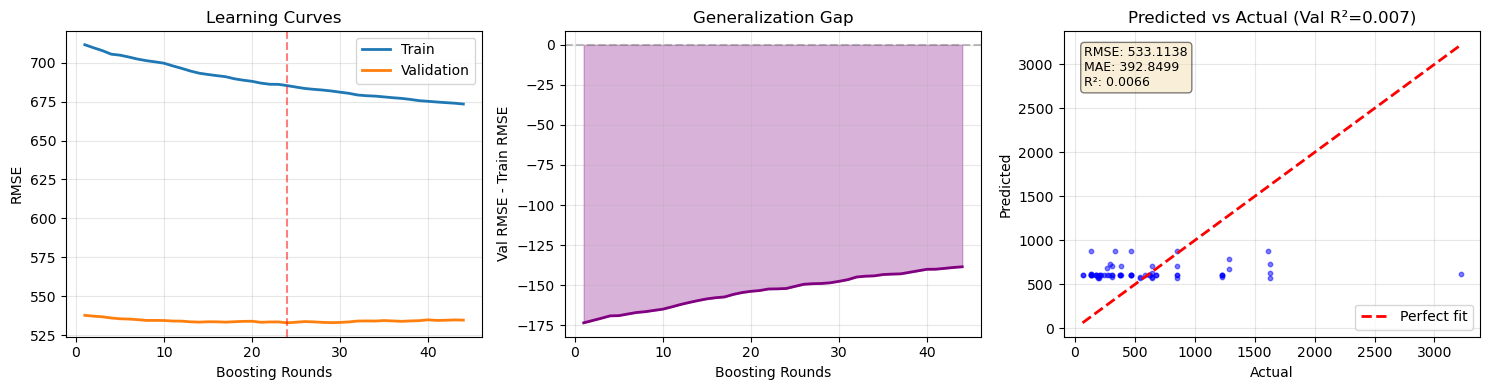

Final Train RMSE: 673.3839
Final Val RMSE: 534.8509
Generalization Gap: -138.5330
Best Val RMSE: 533.1138 at epoch 24


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get metric name for labels
metric_name = LEARNING_CURVES.get('metric_name', 'Loss')

# Learning curves
ax1 = axes[0]
epochs = range(1, LEARNING_CURVES['n_estimators'] + 1)
ax1.plot(epochs, LEARNING_CURVES['train_error'], label='Train', linewidth=2)
ax1.plot(epochs, LEARNING_CURVES['val_error'], label='Validation', linewidth=2)
ax1.set_xlabel('Boosting Rounds')
ax1.set_ylabel(metric_name)
ax1.set_title('Learning Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

min_val_idx = np.argmin(LEARNING_CURVES['val_error'])
ax1.axvline(x=min_val_idx + 1, color='red', linestyle='--', alpha=0.5, label=f'Best val @ {min_val_idx+1}')

# Train-Val gap over time
ax2 = axes[1]
gap = np.array(LEARNING_CURVES['val_error']) - np.array(LEARNING_CURVES['train_error'])
ax2.plot(epochs, gap, color='purple', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.fill_between(epochs, 0, gap, alpha=0.3, color='purple')
ax2.set_xlabel('Boosting Rounds')
ax2.set_ylabel(f'Val {metric_name} - Train {metric_name}')
ax2.set_title('Generalization Gap')
ax2.grid(True, alpha=0.3)

# Third plot: Confusion matrix (classification) or Predicted vs Actual scatter (regression)
ax3 = axes[2]

if PREDICTION_MODE == 'regression':
    # Scatter plot of predicted vs actual for regression
    ax3.scatter(y_val, val_pred, alpha=0.5, s=10, c='blue')
    
    # Add perfect prediction line
    val_min, val_max = min(y_val.min(), val_pred.min()), max(y_val.max(), val_pred.max())
    ax3.plot([val_min, val_max], [val_min, val_max], 'r--', linewidth=2, label='Perfect fit')
    
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.set_title(f'Predicted vs Actual (Val R²={val_r2:.3f})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add text with metrics
    textstr = f'RMSE: {val_rmse:.4f}\nMAE: {mean_absolute_error(y_val, val_pred):.4f}\nR²: {val_r2:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

else:
    # Confusion matrix heatmap for classification
    cm = confusion_matrix(y_val, val_pred, labels=unique)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax3.imshow(cm_normalized, cmap='Blues', vmin=0, vmax=1)
    ax3.set_xticks(range(len(unique)))
    ax3.set_yticks(range(len(unique)))
    ax3.set_xticklabels([CLASS_NAMES[c] for c in unique], rotation=45, ha='right')
    ax3.set_yticklabels([CLASS_NAMES[c] for c in unique])
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')
    ax3.set_title('Validation Confusion Matrix')
    plt.colorbar(im, ax=ax3, shrink=0.8)
    
    for i in range(len(unique)):
        for j in range(len(unique)):
            color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
            ax3.text(j, i, f'{cm_normalized[i, j]:.2f}', ha='center', va='center', color=color, fontsize=8)

plt.tight_layout()
plt.savefig(CURVES_PATH, dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
final_gap = LEARNING_CURVES['val_error'][-1] - LEARNING_CURVES['train_error'][-1]
print(f"Final Train {metric_name}: {LEARNING_CURVES['train_error'][-1]:.4f}")
print(f"Final Val {metric_name}: {LEARNING_CURVES['val_error'][-1]:.4f}")
print(f"Generalization Gap: {final_gap:.4f}")
print(f"Best Val {metric_name}: {min(LEARNING_CURVES['val_error']):.4f} at epoch {min_val_idx + 1}")

## 8. Predict on Full Imagery

Apply the trained model to predict on all valid pixels.

In [10]:
pred_data = np.stack([stacked_ds[name].values for name in feature_names], axis=0)
n_bands, ny, nx = pred_data.shape
pixels = pred_data.reshape(n_bands, -1).T

valid_mask = ~np.isnan(pixels).any(axis=1)

# Apply same standardization as training (if enabled)
pixels_to_predict = pixels[valid_mask]
if FEATURE_SCALER is not None:
    pixels_to_predict = FEATURE_SCALER.transform(pixels_to_predict)
    print(f"Applied {STANDARDIZE_FEATURES} scaling to prediction data")

predictions = np.full(ny * nx, np.nan, dtype=np.float32)

if valid_mask.sum() > 0:
    if PREDICTION_MODE == 'regression':
        # Regression: predict continuous values
        predictions[valid_mask] = clf.predict(pixels_to_predict).astype(np.float32)
        
        # Optional clipping
        clip_range = REGRESSION_CONFIG.get('clip_range')
        if clip_range is not None:
            min_val, max_val = clip_range
            clipped_count = ((predictions[valid_mask] < min_val) | (predictions[valid_mask] > max_val)).sum()
            predictions = np.clip(predictions, min_val, max_val)
            if clipped_count > 0:
                print(f"Clipped {clipped_count:,} predictions to range [{min_val}, {max_val}]")
    else:
        # Classification: predict class labels (1-indexed)
        predictions[valid_mask] = clf.predict(pixels_to_predict).astype(np.float32) + 1

prediction_da = xr.DataArray(
    predictions.reshape(ny, nx),
    dims=['y', 'x'],
    coords={'y': stacked_ds.coords['y'], 'x': stacked_ds.coords['x']},
    name='prediction'
).rio.write_crs(lc_ds.rio.crs)

# Log prediction stats
pred_log = [f"Valid pixels predicted: {valid_mask.sum():,} / {len(valid_mask):,}", ""]
pred_log.append(f"Prediction Mode: {PREDICTION_MODE}")

if PREDICTION_MODE == 'regression':
    valid_preds = predictions[~np.isnan(predictions)]
    pred_log.append("")
    pred_log.append("Predicted Value Distribution:")
    pred_log.append(f"  Min:    {valid_preds.min():.4f}")
    pred_log.append(f"  Max:    {valid_preds.max():.4f}")
    pred_log.append(f"  Mean:   {valid_preds.mean():.4f}")
    pred_log.append(f"  Std:    {valid_preds.std():.4f}")
    pred_log.append(f"  Median: {np.median(valid_preds):.4f}")
    if REGRESSION_CONFIG.get('clip_range'):
        pred_log.append(f"  Clip Range: {REGRESSION_CONFIG['clip_range']}")
else:
    pred_log.append("")
    pred_log.append("Predicted Class Distribution:")
    unique_classes = np.unique(predictions[~np.isnan(predictions)]).astype(int)
    for cls in unique_classes:
        count = (predictions == cls).sum()
        pred_log.append(f"  {CLASS_NAMES[cls-1]:12s}: {count:,} pixels")

log_section("PREDICTION", "\n".join(pred_log))

print(f"Prediction complete. {valid_mask.sum():,} pixels {'regressed' if PREDICTION_MODE == 'regression' else 'classified'}.")

Prediction complete. 417,056 pixels regressed.


## 9. Interactive Visualization

Interactive map with satellite basemap overlay. Hover over pixels to see predicted values.

In [11]:
print("Reprojecting to EPSG:3857 for visualization...")
prediction_wm = prediction_da.rio.reproject("EPSG:3857")

if PREDICTION_MODE == 'regression':
    # REGRESSION MODE: Continuous colormap visualization
    
    # Custom hover for continuous values
    hover = HoverTool(
        tooltips=[
            ('X', '$x{0.0}'), 
            ('Y', '$y{0.0}'), 
            ('Value', '@image{0.4f}')
        ]
    )
    
    # Get value range for colorbar
    valid_vals = prediction_wm.values[~np.isnan(prediction_wm.values)]
    vmin, vmax = np.percentile(valid_vals, [2, 98])  # Use percentiles to handle outliers
    
    img_plot = prediction_wm.hvplot.image(
        x='x', y='y', cmap='viridis', clim=(vmin, vmax), alpha=0.7,
        title=f'Predicted {VECTOR_TRAINING_CONFIG["target_column"]}',
        frame_width=700, frame_height=600,
        colorbar=True, rasterize=False
    ).opts(
        tools=[hover]
    )
    
    print(f"Value range (2nd-98th percentile): {vmin:.4f} to {vmax:.4f}")

else:
    # CLASSIFICATION MODE: Discrete class colormap visualization
    
    # Build class mapping for hover tooltip (dynamic based on CLASS_NAMES)
    class_js = ', '.join([f'{i+1}: "{name}"' for i, name in CLASS_NAMES.items()])
    class_name_formatter = CustomJSHover(code=f"""
        const class_names = {{{class_js}}};
        return class_names[Math.round(value)] || 'NoData';
    """)
    
    hover = HoverTool(
        tooltips=[('X', '$x{0.0}'), ('Y', '$y{0.0}'), ('Class', '@image{custom}')],
        formatters={'@image': class_name_formatter}
    )
    
    # Generate colors dynamically based on number of classes
    import colorsys
    n_classes = len(CLASS_NAMES)
    if n_classes <= 10:
        # Use predefined colors for up to 10 classes
        default_colors = ['#006400', '#90EE90', '#228B22', '#ADFF2F', '#00CED1', 
                          '#0000FF', '#D2B48C', '#808080', '#8B5A2B', '#A0522D']
        colors = default_colors[:n_classes]
    else:
        # Generate evenly spaced colors in HSV space for more classes
        colors = []
        for i in range(n_classes):
            hue = i / n_classes
            rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
            colors.append('#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)))
    
    # Create colorbar tick labels with class names (dynamic)
    from bokeh.models import FixedTicker
    class_ticks = list(range(1, n_classes + 1))
    class_labels = {i+1: name for i, name in CLASS_NAMES.items()}
    
    img_plot = prediction_wm.hvplot.image(
        x='x', y='y', cmap=colors, clim=(0.5, n_classes + 0.5), alpha=0.3,
        title='Land Cover Prediction', frame_width=700, frame_height=600,
        colorbar=True, rasterize=False
    ).opts(
        tools=[hover],
        colorbar_opts={
            'ticker': FixedTicker(ticks=class_ticks),
            'major_label_overrides': class_labels
        }
    )

overlay = gvts.EsriImagery * img_plot
hv.output(overlay)

Reprojecting to EPSG:3857 for visualization...
Value range (2nd-98th percentile): 472.2472 to 1191.9878


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (prediction)

## 10. Export to GeoTIFF

Save the prediction as a GeoTIFF with:
- **Classification:** uint8 with embedded colormap and .clr file
- **Regression:** float32 with NoData value

In [12]:
if PREDICTION_MODE == 'regression':
    # REGRESSION MODE: Export float32 raster with NoData
    output_dtype = REGRESSION_CONFIG.get('output_dtype', 'float32')
    output_nodata = REGRESSION_CONFIG.get('output_nodata', -9999)
    
    # Replace NaN with NoData value
    prediction_out = prediction_da.fillna(output_nodata).astype(output_dtype)
    prediction_out = prediction_out.rio.write_crs(prediction_da.rio.crs)
    prediction_out = prediction_out.rio.write_nodata(output_nodata)
    
    if os.path.exists(OUTPUT_PATH):
        os.remove(OUTPUT_PATH)
    
    prediction_out.rio.to_raster(OUTPUT_PATH, dtype=output_dtype)
    
    # Log output info
    output_log = [
        f"Output Folder: {RUN_OUTPUT_DIR}",
        f"Raster: {OUTPUT_PATH}",
        f"Learning Curves: {CURVES_PATH}",
        f"CRS: {prediction_da.rio.crs}",
        f"Dtype: {output_dtype}, NoData: {output_nodata}",
        f"Prediction Mode: REGRESSION",
        f"Target Column: {VECTOR_TRAINING_CONFIG['target_column']}"
    ]
    
    # Get value statistics
    valid_vals = prediction_da.values[~np.isnan(prediction_da.values)]
    output_log.append("")
    output_log.append("Output Value Statistics:")
    output_log.append(f"  Min:    {valid_vals.min():.4f}")
    output_log.append(f"  Max:    {valid_vals.max():.4f}")
    output_log.append(f"  Mean:   {valid_vals.mean():.4f}")
    
    print(f"Saved (regression): {OUTPUT_PATH}")

else:
    # CLASSIFICATION MODE: Export uint8 raster with colormap
    
    # Generate colormap dynamically based on number of classes
    import colorsys
    n_classes = len(CLASS_NAMES)
    
    # Default colors for up to 10 classes (original colors)
    default_rgba = [
        (0, 100, 0, 255),       # DST - dark green
        (144, 238, 144, 255),   # TST - light green
        (34, 139, 34, 255),     # LTDST - forest green
        (173, 255, 47, 255),    # OST - green yellow
        (0, 206, 209, 255),     # Wet - cyan
        (0, 0, 255, 255),       # Waterbody - blue
        (210, 180, 140, 255),   # PBHV - tan
        (128, 128, 128, 255),   # Barren - gray
        (139, 90, 43, 255),     # SASH - brown
        (160, 82, 45, 255),     # BRN - sienna
    ]
    
    COLORMAP = {0: (0, 0, 0, 0)}  # NoData
    
    if n_classes <= 10:
        # Use default colors
        for i in range(n_classes):
            COLORMAP[i + 1] = default_rgba[i]
    else:
        # Generate colors dynamically for more classes
        for i in range(n_classes):
            hue = i / n_classes
            rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)
            COLORMAP[i + 1] = (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255), 255)
    
    prediction_int = prediction_da.fillna(0).astype('uint8')
    prediction_int = prediction_int.rio.write_crs(prediction_da.rio.crs).rio.write_nodata(0)
    
    if os.path.exists(OUTPUT_PATH):
        os.remove(OUTPUT_PATH)
    
    prediction_int.rio.to_raster(OUTPUT_PATH, dtype='uint8')
    
    with rasterio.open(OUTPUT_PATH, 'r+') as dst:
        dst.write_colormap(1, COLORMAP)
        dst.colorinterp = [ColorInterp.palette]
    
    clr_path = OUTPUT_PATH.replace('.tif', '.clr')
    with open(clr_path, 'w') as f:
        for value, (r, g, b, a) in COLORMAP.items():
            class_name = CLASS_NAMES.get(value - 1, 'NoData') if value > 0 else 'NoData'
            f.write(f"{value} {r} {g} {b}  # {class_name}\n")
    
    # Log output info
    output_log = [
        f"Output Folder: {RUN_OUTPUT_DIR}",
        f"Raster: {OUTPUT_PATH}",
        f"Colormap: {clr_path}",
        f"Learning Curves: {CURVES_PATH}",
        f"CRS: {prediction_da.rio.crs}",
        f"Dtype: uint8, NoData: 0",
        f"Number of classes: {n_classes}",
        f"Prediction Mode: CLASSIFICATION"
    ]
    
    print(f"Saved (classification): {OUTPUT_PATH}")

log_section("OUTPUT", "\n".join(output_log))

# Write run log to file
with open(LOG_PATH, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write(f"XGBOOST {'REGRESSION' if PREDICTION_MODE == 'regression' else 'LAND COVER CLASSIFICATION'} RUN LOG\n")
    f.write("=" * 80 + "\n")
    f.write(f"Timestamp: {RUN_LOG['timestamp']}\n")
    f.write(f"Output: {OUTPUT_PATH}\n")
    f.write(f"Prediction Mode: {PREDICTION_MODE}\n")
    f.write(f"Training Data Mode: {TRAINING_DATA_MODE}\n")
    f.write("=" * 80 + "\n\n")
    
    for section in RUN_LOG['sections']:
        f.write(f"{'='*40}\n")
        f.write(f"{section['title']}\n")
        f.write(f"{'='*40}\n")
        f.write(section['content'] + "\n\n")

print(f"Output folder: {RUN_OUTPUT_DIR}")
print(f"  Raster: {OUTPUT_BASE}.tif")
print(f"  Log: {OUTPUT_BASE}.txt")

Saved (regression): output/PLOT_AGB_CHM_REG_0129_1102/PLOT_AGB_CHM_REG_0129_1102.tif
Output folder: output/PLOT_AGB_CHM_REG_0129_1102
  Raster: PLOT_AGB_CHM_REG_0129_1102.tif
  Log: PLOT_AGB_CHM_REG_0129_1102.txt
